In [1]:
#imports
import pyvista as pv
import numpy as np 
import os
import mne
import pandas as pd 
import pickle
import seaborn as sns
import scipy.stats as stats
import scipy.io as sio
import random as rd 
import pyvista as pv 
import matplotlib.pyplot as plt 
from scipy.spatial import distance
from nilearn.datasets import fetch_surf_fsaverage
from nilearn import surface

# Utils import
from utils.mathutils import compute_vertex_normals, build_template_adjacency_two_hemis, compute_mean_curvature, compute_curvature_differences, compute_hausdorff_metrics, compute_point_distances, compute_normal_differences
from utils.file_manip.Matlab_to_array import load_faces, load_vertices
from utils.cortical import surface_preprocess as sp
from utils.cortical import spherical_harmonics as SH
from utils.mathutils import cart_to_sph
from utils.file_manip.vtk_processing import convert_triangles_to_pyvista

In [2]:
subject_folder = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN\sub-CC721648"
faces_file=os.path.join(subject_folder, "faces_reduced.mat")
vertices_file=os.path.join(subject_folder, "vertices_reduced.mat")
faces = load_faces(faces_file)
vertices = load_vertices(vertices_file)

In [24]:
subject_folder = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN\sub-CC721648"
faces_file=os.path.join(subject_folder, "faces_reduced.mat")
vertices_file=os.path.join(subject_folder, "vertices_reduced.mat")
faces = load_faces(faces_file)
vertices = load_vertices(vertices_file)

# Visualisation avec PyVista
mesh = pv.PolyData(vertices, convert_triangles_to_pyvista(faces))
p = pv.Plotter()
p.add_mesh(mesh, show_edges=True, color='white')
p.show()

Widget(value='<iframe src="http://localhost:30577/index.html?ui=P_0x25ef1ef4e00_3&reconnect=auto" class="pyvis…

In [25]:
# 1. Création d'un source space complet
src_dict = {
    'rr': vertices,  
    'tris': faces,
    'type': 'surf',
    'coord_frame': 4,
    'np': len(vertices), 
    'ntri': len(faces),
    'vertno': np.arange(len(vertices)),
    'inuse': np.ones(len(vertices), dtype=int),
    'nuse': len(vertices),
    'id': 101,  # Left hemi
    'subject_his_id': None,
    'dist': None,
    'dist_limit': None,
    'nearest': None,
    'nearest_dist': None,
    'pinfo': None,
    'patch_inds': None,
    'use_tris': None,
    'nuse_tri': None,
    'workspace': None
}

src = mne.source_space.SourceSpaces([src_dict])

# 2. Données MEG 
raw = mne.io.read_raw_ctf('C:/Users/wbou2/Documents/brainstorm_db/TutorialIntroduction/sample_introduction/sample_introduction/data/S01_AEF_20131218_01_600Hz.ds')

# 3. Forward model 
sphere = mne.make_sphere_model(r0=(0., 0., 0.), head_radius=0.09)
fwd = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere, meg=True)

ds directory : C:\Users\wbou2\Documents\brainstorm_db\TutorialIntroduction\sample_introduction\sample_introduction\data\S01_AEF_20131218_01_600Hz.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       2.51   74.26    0.00 mm <->    2.51   74.26   -0.00 mm (orig :  -56.69   50.20 -264.38 mm) diff =    0.000 mm
      -2.51  -74.26    0.00 mm <->   -2.51  -74.26   -0.00 mm (orig :   50.89  -52.31 -265.88 mm) diff =    0.000 mm
     108.63    0.00    0.00 mm <->  108.63    0.00    0.00 mm (orig :   67.41   77.68 -239.53 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['C:\\Users\\wbou2\\Documents\\brainstorm_db\\TutorialIntroduction\\sample_introduction\\sample_introduction\\data\\S01_AEF_20131218_01_600Hz.ds\\S01_20131218_01.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of

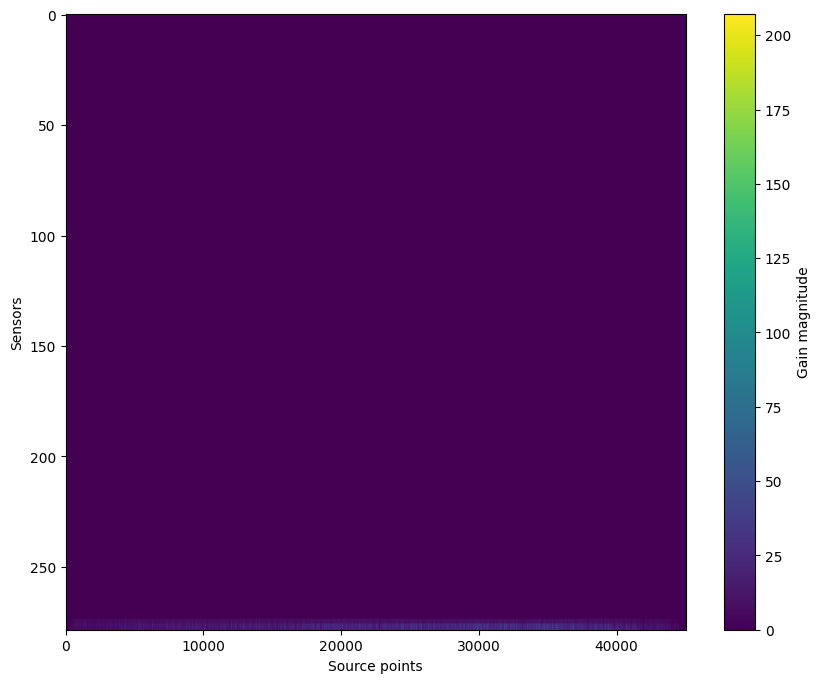

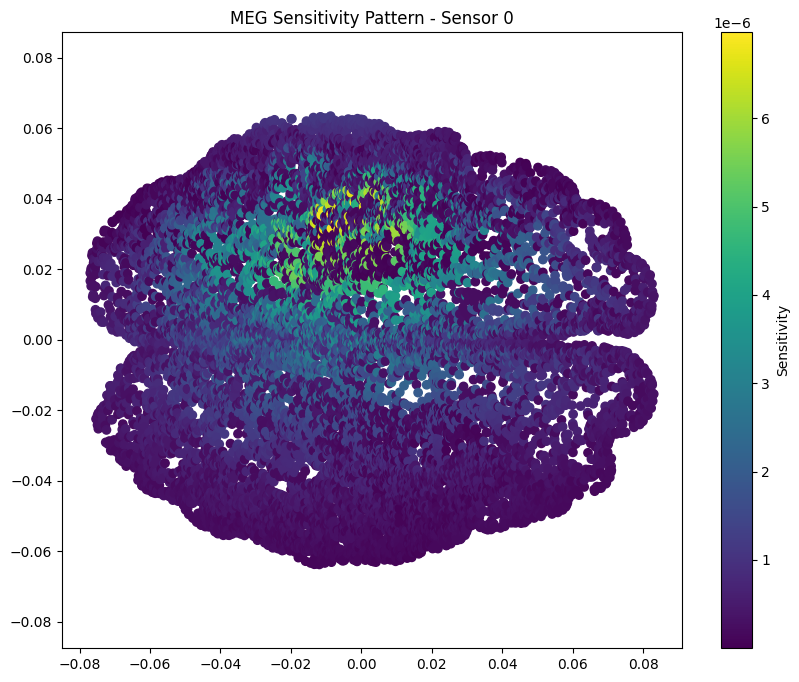

In [26]:


# 1. Gain matrix
gain = fwd['sol']['data']
plt.figure(figsize=(10,8))
plt.imshow(np.abs(gain), aspect='auto', cmap='viridis')
plt.colorbar(label='Gain magnitude')
plt.xlabel('Source points')
plt.ylabel('Sensors')
plt.show()

# 2. Source space
plt.figure(figsize=(10,8))
plt.scatter(vertices[:,0], vertices[:,1], c=np.abs(gain[0,::3]), cmap='viridis')
plt.colorbar(label='Sensitivity')
plt.title(f'MEG Sensitivity Pattern - Sensor 0')
plt.axis('equal')
plt.show()